In [27]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
import catboost as cab

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.logging.get_verbosity()

In [28]:
test_data = pd.read_csv('data/test/000000000000.csv', sep='\t')
test_data.shape 

KeyboardInterrupt: 

In [ ]:
train_data = pd.read_csv('./data/train.csv', sep='\t')
train_data.shape 

(3485852, 82)

In [ ]:
train_data = train_data.replace([np.inf, -np.inf], np.nan).fillna(0)
test_data = test_data.replace([np.inf, -np.inf], np.nan).fillna(0)

In [ ]:
data = pd.concat([train_data, test_data])

In [ ]:
cat_features = ['f_{}'.format(i) for i in range(1, 42)]
bin_features = ['f_{}'.format(i) for i in range(33, 42)]
num_features = ['f_{}'.format(i) for i in range(42, 80)]
date_features = ['f_1']

In [ ]:
for f in cat_features:
    le = LabelEncoder()
    data[f] = le.fit_transform(data[f])

In [ ]:
zero_count = data.eq(0).sum()  # 计算每列中值为 0 的数量
zero_ratio = zero_count / len(data)  # 计算每列中值为 0 的占比
print(zero_ratio)

f_0             0.000000
f_1             0.038446
f_2             0.005263
f_3             0.290339
f_4             0.002065
                  ...   
f_77            0.998190
f_78            0.973566
f_79            0.990726
is_clicked      0.745728
is_installed    0.789522
Length: 82, dtype: float64


In [ ]:
zero_ratio = zero_ratio.sort_values(ascending=False)
zero_ratio.apply(lambda x: round(x, 5))
zero_ratio.to_csv('./output/zero.csv')

In [ ]:
# for i in range(len(num_features)):
#     for j in range(i + 1, len(num_features)):
#         data[f'{num_features[i]}+{num_features[j]}'] = data[num_features[i]] + data[num_features[j]]
#         data[f'{num_features[i]}-{num_features[j]}'] = data[num_features[i]] - data[num_features[j]]
#         data[f'{num_features[i]}*{num_features[j]}'] = data[num_features[i]] * data[num_features[j]]
#         data[f'{num_features[i]}/{num_features[j]}'] = data[num_features[i]] / (data[num_features[j]] + 1e-7)
# data.shape 

In [ ]:
# for i in range(len(bin_features)):
#     for j in range(i + 1, len(bin_features)):
#         data[f'{bin_features[i]}and{bin_features[j]}'] = data[bin_features[i]] & data[bin_features[j]]
#         data[f'{bin_features[i]}or{bin_features[j]}'] = data[bin_features[i]] | data[bin_features[j]]
#         data[f'{bin_features[i]}xor{bin_features[j]}'] = data[bin_features[i]] ^ data[bin_features[j]]
# data.shape 

In [ ]:
features = [fe for fe in data.columns if fe not in ['is_clicked', 'is_installed', 'f_0', 'label']]
len(features)

79

In [ ]:
train = data[~data['is_clicked'].isna()]
test = data[data['is_clicked'].isna()]
is_clicked_label = train['is_clicked'].astype('int')
is_installed_label = train['is_installed'].astype('int')

train.shape, test.shape, is_clicked_label.shape, is_installed_label.shape 

((3485852, 82), (160973, 82), (3485852,), (3485852,))

In [ ]:
seed = 42
K = 5

In [ ]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    # 'metric': 'binary_logloss',  # auc??
    'metric': 'binary_logloss',
    'n_jobs': 30,
    'learning_rate': 0.05,
    'num_leaves': 2 ** 6,
    'max_depth': 8,
    'tree_learner': 'serial',
    'colsample_bytree': 0.8,
    'subsample_freq': 1,
    'subsample': 0.8,
    'num_boost_round': 3000,
    'max_bin': 255,
    'verbose': -1,
    'nthread' : -1,
    'seed': seed,
    'bagging_seed': seed,
    'feature_fraction_seed': seed,
    'early_stopping_rounds': 100,
    # 'device': 'gpu',  # 设置使用 GPU 加速
    # 'gpu_platform_id': 0,  # 设置 GPU 平台 id
    # 'gpu_device_id': 0  # 设置 GPU 设备 id
}

In [ ]:
KF = StratifiedKFold(n_splits=K, random_state=seed, shuffle=True)

In [ ]:
label = is_clicked_label

In [ ]:
study_lgb = optuna.create_study(direction="minimize", study_name="LGBM Reg is_clicked", sampler=optuna.samplers.TPESampler())
# study_lgb = optuna.create_study(direction="maximize", study_name="LGBM Classifier", sampler=optuna.samplers.GridSampler())

func = lambda trial: objective(trial, train, label)
study_lgb.optimize(func, n_trials=200)

print(f"\tBest value (LogLoss): {study_lgb.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_lgb.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
label = is_installed_label

In [ ]:
# 目前使用训练集的最后一天作为评估集????????????????????

In [ ]:
study_lgb = optuna.create_study(direction="minimize", study_name="LGBM Reg is_installed", sampler=optuna.samplers.TPESampler())

func = lambda trial: objective(trial, train, label)
study_lgb.optimize(func, n_trials=500)

print(f"\tBest value (LogLoss): {study_lgb.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_lgb.best_params.items():
    print(f"\t\t{key}: {value}")

fold n°0
Training until validation scores don't improve for 500 rounds
[50]	training's binary_logloss: 0.344971	valid_1's binary_logloss: 0.345618
[100]	training's binary_logloss: 0.317048	valid_1's binary_logloss: 0.318246
[150]	training's binary_logloss: 0.305897	valid_1's binary_logloss: 0.30772
[200]	training's binary_logloss: 0.300174	valid_1's binary_logloss: 0.30274
[250]	training's binary_logloss: 0.296051	valid_1's binary_logloss: 0.299349
[300]	training's binary_logloss: 0.293404	valid_1's binary_logloss: 0.297486
[350]	training's binary_logloss: 0.291004	valid_1's binary_logloss: 0.295843
[400]	training's binary_logloss: 0.289048	valid_1's binary_logloss: 0.294642
[450]	training's binary_logloss: 0.287527	valid_1's binary_logloss: 0.293921
[500]	training's binary_logloss: 0.28589	valid_1's binary_logloss: 0.293025
[550]	training's binary_logloss: 0.284597	valid_1's binary_logloss: 0.292516
[600]	training's binary_logloss: 0.28335	valid_1's binary_logloss: 0.292028
[650]	trai

[W 2023-05-05 02:06:47,142] Trial 3 failed with parameters: {'n_estimators': 10000, 'learning_rate': 0.025, 'num_leaves': 904, 'max_depth': 15, 'min_split_gain': 0.30000000000000004, 'subsample': 0.8, 'subsample_freq': 10, 'colsample_bytree': 0.6, 'alpha': 0.4, 'lambda': 4.0} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/panda/anaconda3/envs/libcityng/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-26-ad67c2573925>", line 4, in <lambda>
    func = lambda trial: objective(trial, train, label)
  File "<ipython-input-24-8a49b3a4229c>", line 38, in objective
    clf = lgb.train(
  File "/home/panda/anaconda3/envs/libcityng/lib/python3.9/site-packages/lightgbm/engine.py", line 292, in train
    booster.update(fobj=fobj)
  File "/home/panda/anaconda3/envs/libcityng/lib/python3.9/site-packages/lightgbm/basic.py", line 3021, in update
    _safe_call(_

KeyboardInterrupt: 

In [ ]:
logloss = metrics.log_loss(label, [1 if i >= 0.5 else 0 for i in oof_lgb_cli], labels=[0, 1])
acc = metrics.roc_auc_score(label, oof_lgb_cli)
precision = metrics.precision_score(label, [1 if i >= 0.5 else 0 for i in oof_lgb_cli])
recall = metrics.recall_score(label, [1 if i >= 0.5 else 0 for i in oof_lgb_cli])
f1 = metrics.f1_score(label, [1 if i >= 0.5 else 0 for i in oof_lgb_cli])

print(f"Logloss: {logloss:.4f}, AUC: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Logloss: 4.0461, AUC: 0.8730, Precision: 0.8973, Recall: 0.5275, F1 Score: 0.6644


In [ ]:
is_clicked_lgb = [1 if i >= best_threshold_cli else 0 for i in predictions_lgb_cli]
sum(is_clicked_lgb)

68440

In [ ]:
sum(is_clicked_lgb)

68440

In [ ]:
avg_imp_cli = pd.DataFrame(feat_imp_lgb_cli, columns = features).apply(np.mean, axis = 0).sort_values(ascending=False)
avg_imp_cli.describe()

count       79.000000
mean      2368.427848
std       2512.904295
min          0.000000
25%        306.400000
50%       1528.600000
75%       3867.800000
max      10167.800000
dtype: float64

In [ ]:
avg_imp_cli

f_4     10167.8
f_11     9483.6
f_15     9031.4
f_42     8753.8
f_6      8142.2
         ...   
f_29        0.0
f_7         0.0
f_28        0.0
f_27        0.0
f_26        0.0
Length: 79, dtype: float64

is_installed

In [ ]:
label = is_installed_label

In [ ]:
label = is_installed_label

KF = StratifiedKFold(n_splits=K, random_state=seed, shuffle=True)
feat_imp_lgb_ins = list()

oof_lgb_ins = np.zeros(len(train))
predictions_lgb_ins = np.zeros((len(test)))
print(len(features))

# 模型训练
for fold_, (trn_idx, val_idx) in enumerate(KF.split(train.values, label.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=label.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=label.iloc[val_idx])
    
    num_round = 3000
    clf = lgb.train(
        lgb_params,
        trn_data,
        num_round,
        valid_sets=[trn_data, val_data],
        verbose_eval=300,
        early_stopping_rounds=100,
    )

    oof_lgb_ins[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions_lgb_ins[:] += clf.predict(test[features], num_iteration=clf.best_iteration) / K
    feat_imp_lgb_ins.append(clf.feature_importance())

79
fold n°0
Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.875921	valid_1's auc: 0.873932
[600]	training's auc: 0.883247	valid_1's auc: 0.878936
[900]	training's auc: 0.887544	valid_1's auc: 0.880815
[1200]	training's auc: 0.891024	valid_1's auc: 0.881982
[1500]	training's auc: 0.893886	valid_1's auc: 0.882578
[1800]	training's auc: 0.896527	valid_1's auc: 0.883067
[2100]	training's auc: 0.898997	valid_1's auc: 0.883451
[2400]	training's auc: 0.901315	valid_1's auc: 0.883738
[2700]	training's auc: 0.9035	valid_1's auc: 0.883952
[3000]	training's auc: 0.905566	valid_1's auc: 0.884137
Did not meet early stopping. Best iteration is:
[3000]	training's auc: 0.905566	valid_1's auc: 0.884137
fold n°1
Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.876045	valid_1's auc: 0.873745
[600]	training's auc: 0.883256	valid_1's auc: 0.878702
[900]	training's auc: 0.887612	valid_1's auc: 0.880688
[1200]	training's auc: 0.891033

In [ ]:
study_lgb = optuna.create_study(direction="minimize", study_name="LGBM Reg is_installed", sampler=optuna.samplers.TPESampler())
# study_lgb = optuna.create_study(direction="maximize", study_name="LGBM Classifier", sampler=optuna.samplers.GridSampler())

func = lambda trial: objective(trial, train, label)
study_lgb.optimize(func, n_trials=500)

print(f"\tBest value (LogLoss): {study_lgb.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_lgb.best_params.items():
    print(f"\t\t{key}: {value}")

fold n°0


[W 2023-04-28 14:05:08,061] Trial 0 failed with parameters: {'n_estimators': 1000, 'learning_rate': 0.07, 'num_leaves': 640, 'max_depth': 12, 'min_split_gain': 0.4, 'subsample': 0.9, 'subsample_freq': 0.8, 'colsample_bytree': 0.7, 'alpha': 0.7000000000000001, 'lambda': 14.0} because of the following error: LightGBMError('Parameter bagging_freq should be of type int, got "0.8"').
Traceback (most recent call last):
  File "/home/panda/anaconda3/envs/libcityng/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-54-ad67c2573925>", line 4, in <lambda>
    func = lambda trial: objective(trial, train, label)
  File "<ipython-input-48-35dca9957f30>", line 38, in objective
    clf = lgb.train(
  File "/home/panda/anaconda3/envs/libcityng/lib/python3.9/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/home/panda/anaconda3/envs/libcityng/lib/p

LightGBMError: Parameter bagging_freq should be of type int, got "0.8"

In [ ]:
logloss = metrics.log_loss(label, [1 if i >= 0.5 else 0 for i in oof_lgb_ins], labels=[0, 1])
acc = metrics.roc_auc_score(label, oof_lgb_ins)
precision = metrics.precision_score(label, [1 if i >= 0.5 else 0 for i in oof_lgb_ins])
recall = metrics.recall_score(label, [1 if i >= 0.5 else 0 for i in oof_lgb_ins])
f1 = metrics.f1_score(label, [1 if i >= 0.5 else 0 for i in oof_lgb_ins])

print(f"Logloss: {logloss:.4f}, AUC: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Logloss: 4.2917, AUC: 0.8839, Precision: 0.7904, Recall: 0.3892, F1 Score: 0.5216


100%|██████████| 80/80 [00:52<00:00,  1.52it/s]

best_threshold_ins:  0.47999999999999976
best_score_ins:  4.2885554717159


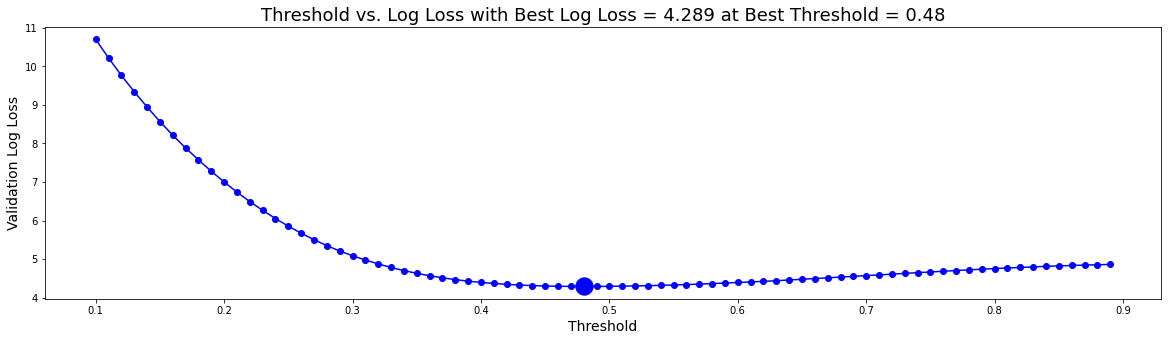

In [ ]:
scores = []; thresholds = []
best_score_ins = 1e30; best_threshold_ins = 0

for threshold in tqdm(np.arange(0.1,0.9,0.01)):
    # print(f'{threshold:.02f}, ',end='')
    m = metrics.log_loss(label, np.where(oof_lgb_ins > threshold, 1, 0), labels=[0, 1])
    scores.append(m)
    thresholds.append(threshold)
    if m < best_score_ins:
        best_score_ins = m
        best_threshold_ins = threshold

print('best_threshold_ins: ', best_threshold_ins)
print('best_score_ins: ', best_score_ins)

plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_ins], [best_score_ins], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation Log Loss',size=14)
plt.title(f'Threshold vs. Log Loss with Best Log Loss = {best_score_ins:.3f} at Best Threshold = {best_threshold_ins:.3}',size=18)
plt.show()

In [ ]:
# scores = []; thresholds = []
# best_score_ins = 0; best_threshold_ins = 0

# for threshold in tqdm(np.arange(0.1,0.9,0.01)):
#     # print(f'{threshold:.02f}, ',end='')
#     m = metrics.f1_score(label, np.where(oof_lgb_ins > threshold, 1, 0), average='binary')
#     scores.append(m)
#     thresholds.append(threshold)
#     if m > best_score_ins:
#         best_score_ins = m
#         best_threshold_ins = threshold

# print('best_threshold_ins: ', best_threshold_ins)
# print('best_score_ins: ', best_score_ins)

# plt.figure(figsize=(20,5))
# plt.plot(thresholds,scores,'-o',color='blue')
# plt.scatter([best_threshold_ins], [best_score_ins], color='blue', s=300, alpha=1)
# plt.xlabel('Threshold',size=14)
# plt.ylabel('Validation F1',size=14)
# plt.title(f'Threshold vs. F1 with F1 = {best_score_ins:.3f} at Best Threshold = {best_threshold_ins:.3}',size=18)
# plt.show()

In [ ]:
logloss = metrics.log_loss(label, [1 if i >= best_threshold_ins else 0 for i in oof_lgb_ins], labels=[0, 1])
acc = metrics.roc_auc_score(label, oof_lgb_ins)
precision = metrics.precision_score(label, [1 if i >= best_threshold_ins else 0 for i in oof_lgb_ins])
recall = metrics.recall_score(label, [1 if i >= best_threshold_ins else 0 for i in oof_lgb_ins])
f1 = metrics.f1_score(label, [1 if i >= best_threshold_ins else 0 for i in oof_lgb_ins])

print(f"Logloss: {logloss:.4f}, AUC: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Logloss: 4.2805, Accuracy: 0.8843, Precision: 0.7682, Recall: 0.4122, F1 Score: 0.5365


In [ ]:
is_installed_lgb = [1 if i >= best_threshold_ins else 0 for i in predictions_lgb_ins]
sum(is_installed_lgb)

19324

In [ ]:
train_data['is_clicked'].mean()

0.21983549502388514

In [ ]:
np.mean(is_clicked_lgb)

0.4251644685754754

In [ ]:
train_data['is_installed'].mean()

0.17401828878563977

In [ ]:
np.mean(is_installed_lgb)

0.12004497648674001

In [ ]:
avg_imp_ins = pd.DataFrame(feat_imp_lgb_ins, columns = features).apply(np.mean, axis = 0).sort_values(ascending=False)
avg_imp_ins.describe()

count      79.000000
mean     2390.000000
std      2421.359227
min         0.000000
25%       359.000000
50%      1792.400000
75%      3875.200000
max      9312.400000
dtype: float64

In [ ]:
avg_imp_ins

f_15    9312.4
f_42    9012.0
f_11    8785.8
f_6     8591.8
f_4     8244.8
         ...  
f_28       0.2
f_29       0.0
f_7        0.0
f_27       0.0
f_26       0.0
Length: 79, dtype: float64

In [ ]:
submission = pd.DataFrame()
submission["RowId"] = test_data["f_0"]
submission["is_clicked"] = is_clicked_lgb
submission["is_installed"] = is_installed_lgb
submission.to_csv('./output/lgb_42_sep_train_auc.csv', index=False, sep='\t')